# Quantum Control as Polynomial Optimization: Piecewise constant controls 

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [1]:
Threads.nthreads()

1

In [2]:
using LinearAlgebra
using DynamicPolynomials
using TSSOS
using SpecialFunctions
using HDF5

## Quantum system

In [3]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V ./= norm(V, Inf);

## Chebyshve polynomial approximation for $\exp(\Delta t \Omega)$

In [4]:
"""
Chebyshev approximation for exp(Δt Ω)
"""
function exp_chebyshev(Δt::Real, Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, Δt) * Tₙ₋₁ + 2 * besselj(1, Δt) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, Δt) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

In [5]:
@polyvar x[1:2]

# final time
const T = 0.5

Δt = T / size(x)[1]

𝓤 = prod(exp_chebyshev(Δt, -im * (H0 + ξ * V), 7) for ξ in x);

## Utilities

In [6]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

function scaling_poly(p::Polynomial)
    #=
    Estimate the scaling factor for the variables of a polynomial to make TSSOS computations numerically stable 
    
    see https://github.com/wangjie212/TSSOS/issues/6
    =#    
    X = transpose(hcat([exponents(t) for t in terms(p)]...))
    
    # Get the scaling via linear regression  
    scaling = X \ log.(abs.(coefficients(p)))
    
    exp.(abs.(scaling))
end

function propagate(x::AbstractArray)   
    #=
    Solve the equation of motion
    =#
    prod(exp(-im * Δt * (H0 + ξ * V)) for ξ in x)
end

function 𝓤_propagation(x::AbstractArray)   
    map(z -> z(x), 𝓤)
end

𝓤_propagation (generic function with 1 method)

## Read target unitiries

In [7]:
h5open("results.hdf5", "r") do fid
    global U_targets = read(fid["U_targets"])
    global magnus_norm_U_target_minus_obtained = read(fid["norm_U_target_minus_obtained"])
    global magnus_f_PSU = read(fid["f_PSU"]) 
end;

In [8]:
@time begin
    
n_samples = size(U_targets)[1]

# piecewise constant controls 
piecewise_const_x = zeros((n_samples, length(x)))
    
# Frobenius norm difference between target and obtained unitaries
norm_U_target_minus_obtained = zeros(n_samples)

# Difference between symbolic exponent and exact to check accuracy  
norm_𝓤_propagation_exact = zeros(n_samples)

# The normalised overlap of the evolution and the target 
f_PSU = zeros(n_samples) 
    
Threads.@threads for i=1:n_samples
    
    # target unitray
    U_target = U_targets[i, :, :]
        
    # get the polynomial objective function
    obj = square_frobenius_norm(
        U_target - 𝓤
    )
    
    # scale polynomial to make TSSOS computations numerically stable 
    scaling = scaling_poly(obj)
    obj = subs(obj, x => scaling .* x)  
        
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true, solution = true)
    
    previous_sol = sol
    previous_opt = opt
    
    while ~isnothing(sol)
        previous_sol = sol
        previous_opt = opt
            
        opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
    end

    min_x = scaling .* previous_sol

    # saving the found controls
    piecewise_const_x[i, :] = min_x
        
    # Frobenius norm difference between target and obtained unitaries
    U_obtained = propagate(min_x)
    norm_U_target_minus_obtained[i] = norm(U_target - U_obtained)
        
    # The normalised overlap of the evolution and the target 
    f_PSU[i] = abs(tr(U_target' * U_obtained)) / size(U_obtained)[1]
        
    # Difference between symbolic exponent and exact to check accuracy 
    norm_𝓤_propagation_exact[i] = norm(U_obtained - 𝓤_propagation(min_x))   
end
    
end

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.1015697269463245e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 1.6914508655181224e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.544061670942167e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.817623335486154e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.5311116761694534e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.258918496132429e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023

TSSOS is launching...
optimum = -3.5829761602549088e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.2552210697188912e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.0580651175866693e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -9.919588220202123e-10
Global optimality certified with relative optimality gap 0.000000%!
N

optimum = -3.5291733217006697e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.3844308279636677e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.5550050996674895e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.319334863714606e-8
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.7146956059309845e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.3686930636715976e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.3292018560855382e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Vers

Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -8.443777479733087e-11
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.0386931478886966e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.4128663621092727e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.91201635985497e-11
Global optimality cer

Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.468257355568461e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.634780653944331e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.0748390891913362e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.9706987089113624e-9
Global optimality cert

Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.6484544390123296e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.657048033170995e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.6401496667109621e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
***************

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.2923269819702157e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.5101358905800384e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.725030753109295e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Versi

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.025204607027969e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.621097589082959e-9
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.677705402531699e-8
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023


TSSOS is launching...
optimum = -3.6827062119211963e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -8.368305041979265e-10
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.9477427435478558e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.0838487758065243e-9
Global optimality certified with relative optimality gap 0.000000%!
N

optimum = -4.128399929336816e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.8023425334672335e-9
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.334796040402835e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.9482935544003105e-9
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the 

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.3795242731098233e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.6597959483048605e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.824624352373989e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Versi

Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.985378455210278e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 3.0300168406905943e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.6699449337000745e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.9739210644052937e-10
Global optimality cer

TSSOS is launching...
optimum = 4.113957083662648e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 2.0815889664020665e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.4319326049419793e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -5.0657221709541505e-9
Global optimality certified with relative optimality gap 0.000001%!
No h

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.5766473636253766e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -6.340187827380255e-10
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.337852930255442e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Versi

Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 1.1758463646982768e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 7.274996019809112e-10
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.1909877594542525e-8
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.19584676449503e-9
Global optimality certif

Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.666878361854455e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 1.924153915385306e-10
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.855995648944361e-9
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.2961956454341097e-9
Global optimality certi

Global optimality certified with relative optimality gap 0.000004%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -8.352385381555855e-10
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.5137393440920253e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.4109022816834104e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
**************

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 5.83787736087204e-10
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.993981843076826e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.8419742580825231e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 2.0428465402572467e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.474210988003163e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.0050318398420507e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023

TSSOS is launching...
optimum = -1.0010796713465036e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.6742243461931006e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.0403203907282099e-8
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.69830179645704e-9
Global optimality certified with relative optimality gap 0.000001%!
No 

optimum = -4.567381487179225e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.0195946064907126e-8
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.3964639139653194e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 1.0805220119009623e-8
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the 

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.1108492244194426e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.406887606100767e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.3497976909312208e-8
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Versi

Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.5547000615383782e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.7954739982263424e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.80094209096871e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.928896704183753e-9
Global optimality certi

Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -1.12592230351123e-8
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.9270009875236165e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.4924620367110907e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 1.5044785239636144e-9
Global optimality certi

Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.023428405685441e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.284724641260711e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -2.8184682552901364e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
****************

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.164769553159543e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.1698503941456523e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 1.0367816208650703e-11
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Versi

No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.33242735729648e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -3.769011438094947e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = -4.065357674864629e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 

## Save results

In [9]:
h5open("results_PiecewiseConst.hdf5", "w") do fid
    fid["U_targets"] = U_targets
    fid["piecewise_const_x"] = piecewise_const_x
    fid["f_PSU"] = f_PSU
    fid["norm_U_target_minus_obtained"] = norm_U_target_minus_obtained
end;

## Analysis

In [10]:
using PyPlot

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


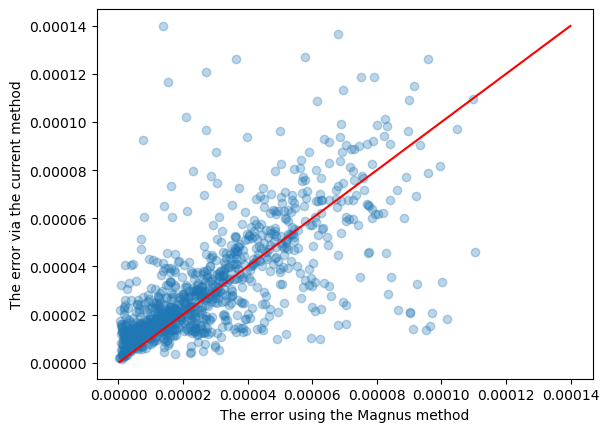

In [11]:
scatter(magnus_norm_U_target_minus_obtained, norm_U_target_minus_obtained, alpha=0.3)

lower = min(minimum(magnus_norm_U_target_minus_obtained), minimum(norm_U_target_minus_obtained))
higher = max(maximum(magnus_norm_U_target_minus_obtained), maximum(norm_U_target_minus_obtained))
plot([lower, higher], [lower, higher], "r")

xlabel("The error using the Magnus method")
ylabel("The error via the current method")
show()

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


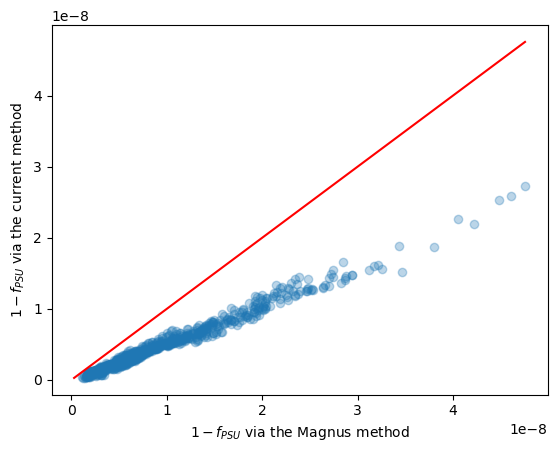

In [12]:
magnus_ε = 1 .- magnus_f_PSU
ε = 1 .- f_PSU

scatter(magnus_ε, ε,  alpha=0.3)

lower = min(minimum(magnus_ε), minimum(ε))
higher = max(maximum(magnus_ε), maximum(ε))
plot([lower, higher], [lower, higher], "r")

xlabel(L"1 - f_{PSU}" * " via the Magnus method")
ylabel(L"1 - f_{PSU}" * " via the current method")
show()